In [ ]:
#%source bin/activate
import tensorflow as tf
import random
import time
import matplotlib.pyplot as plt
import matplotlib.patches as pypatch
import numpy as np
from tensorflow.contrib import rnn
from datetime import datetime

%matplotlib inline

cos, sin = np.cos, np.sin
twopi = np.pi*2.0

In [1]:
def plotLine(x1,y1,x2,y2,c='b',ax=None):
    if ax: # given axis handle
        ax.plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=0.2)
    else:
        plt.gca().plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=0.2) 

In [6]:
rundir = "/home/walterms/project/walterms/mcmd/nn/data/"
trndir = rundir+"train/"
testdir = rundir+"test/"

summdir = "/home/walterms/project/walterms/mcmd/nn/tfrnn/summaries/"

bThetas = False
nrod = 400
NLBL = 6
batchsize = 500
seq_len = 10

nblPerTrnFile = 9000
nblPerTestFile = 300

trnlist = ["xmelt"]

trnlist = [trndir+x for x in trnlist]
testlist = [testdir+x for x in testlist]

In [7]:
# Compile time seq training set
trn_data_seq = []
            
sortIdx = np.arange(nrod,dtype=int)

features = ["x","y","th"]
# features = ["x","y","ft1","ft2"]
featdict = {}
for ft in features:
    featdict.update({ft:[]})

nchannel = len(features)
if bThetas: nchannel = 1

for f in trnlist:
    print "Processing " + f + " as training data"
    IDs = []
    fin = open(f, 'r')
    nTrn = 0
    for line in fin.readlines():
        if line == "\n":
            # Done a block
            # Sort based on rod indices
            sortIdx = np.argsort(IDs)
            
            if bThetas:
                thdata = None
                thdata = (-0.5) + np.asarray(thetas)[sortIdx]
                formatted_data = np.stack([thdata,thdata,thdata])
                #thdata = thdata.reshape(1,nrod)
                trn_data_seq.append(formatted_data)

            else:
                # Insert data as triplets
                channels = []
                for ft in features:
                    channels.append(featdict[ft])
                prep_data = []
                for ch in channels:
                    prep_data.append(np.asarray(ch)[sortIdx])
#                     prep_data.append((-0.5)+np.asarray(ch)[sortIdx])
                formatted_data = np.stack(prep_data)
                trn_data_seq.append(formatted_data)
                
            for ft in features:
                featdict[ft] = []
            IDs = []
            nTrn+=1
            if nTrn == nblPerTrnFile+nblPerTestFile: 
                break
            continue
        spt = [float(x) for x in line.split()]
        featdict["x"].append(spt[0]-0.5)
        featdict["y"].append(spt[1]-0.5)
        th = spt[2]-0.5
#         th = np.arctan(sin(np.pi*th)/cos(np.pi*th))
        featdict["th"].append(th)
        
        IDs.append(int(spt[3]))

    fin.close()
    
trn_data_seq = np.asarray(trn_data_seq)
splitpoint = nblPerTestFile - (nblPerTestFile%seq_len)
test_data_seq = trn_data_seq[-splitpoint:]
trn_data_seq = trn_data_seq[0:len(trn_data_seq)-splitpoint]
    
print "Done compiling seq sets"
print "len(train):",len(trn_data_seq),"len(test)",len(test_data_seq)

Processing /home/walterms/project/walterms/mcmd/nn/data/train/xmelt as training data
Done compiling seq sets
len(train): 9000 len(test) 300


In [15]:
400*trn_data_seq.nbytes/1073741824.0

32.18650817871094

In [9]:
trn_data_seq.itemsize

8

In [37]:
###################
#       RNN       # 
###################

tf.reset_default_graph()

eta = 1e-2
nInput = nrod
nHidden = 32
nDense = 32
subnlayer = 1
seqnlayer = 3

# sizedict = {"nchannel": nchannel,
#             "batchsize": batchsize,
#             "nHidden": nHidden,
#             "nLayer": nLayer,
#             "NLBL": NLBL}

def variable_summaries(var):
    #A ttach a lot of summaries to a Tensor (for TensorBoard visualization)
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


X = tf.placeholder("float", [None, seq_len, nchannel, nInput],name="X")
Y = tf.placeholder("float", [None, nchannel, nInput],name="Y")

with tf.name_scope('dense'):
    dense_weights = {"pre":tf.Variable(tf.random_normal([nHidden,nDense],
                stddev=0.1,dtype=tf.float32),name="pre_w")}
    for f in features:
        dense_weights.update({f:tf.Variable(tf.random_normal([nDense,nrod],
                stddev=0.1,dtype=tf.float32),name=f+"_w")})

    dense_biases = {"pre":tf.Variable(tf.random_normal([nDense],
                stddev=0.1,dtype=tf.float32),name="pre_b")}
    for f in features:
        dense_biases.update({f:tf.Variable(tf.random_normal([nrod],
                stddev=0.1,dtype=tf.float32),name=f+"_b")})
        
    for w in dense_weights:
        tf.summary.histogram(w+"_ws",dense_weights[w])
    for b in dense_biases:
        tf.summary.histogram(b+"_bs",dense_biases[b])


# Define an lstm cell with tensorflow
def lstm_cell(nUnits):
    return rnn.BasicLSTMCell(nUnits)

def seqRNN(x):

    x = tf.unstack(x,seq_len,1) # unstack along time dimension
    
    with tf.name_scope('subrnn'):
        with tf.variable_scope('subrnn'):
            # Subcell    
#             subcell = lstm_cell(nHidden)
            subcell = rnn.MultiRNNCell([lstm_cell(nHidden) for _ in range(subnlayer)])

            suboutputs = []
            substate = subcell.zero_state(batchsize,tf.float32)

            # Loop over the images in a sequence
            for x_img in x:
                x_ = tf.unstack(x_img,nchannel,1)
                # Returns multiple outputs I think of size [batchsize,nchannel,subcell.output_size]
                suboutput_img, substate = tf.nn.static_rnn(subcell,x_,dtype=tf.float32,initial_state=substate)
                # suboutput_img is a list of 3 outputs from each iteration on the img
                # suboutput_img[-1] is the last output, let's use that as input to the seqrnn
                suboutputs.append(suboutput_img[-1])

            tf.summary.histogram('substate',substate)

    with tf.name_scope('seqrnn'):
        with tf.variable_scope('seqrnn'):
            # Main cell
#             cell = lstm_cell(nHidden)
            cell = rnn.MultiRNNCell([lstm_cell(nHidden) for _ in range(seqnlayer)])

            outputs,state = tf.nn.static_rnn(cell,suboutputs,dtype=tf.float32)
            tf.summary.histogram('cellstate',state)


    # Dense output from seqrnn
    with tf.name_scope('dense'):
        dense_pre = tf.nn.elu(tf.add(tf.matmul(outputs[-1],dense_weights["pre"]),
                        dense_biases["pre"]),name="pre_out_activ")

        # Tensors for transforming output of main RNN unit into an img
        out_img_channels = []
        i = 0
        for ft in features:
    #             out_img_channels.append(tf.squeeze(tf.slice(y,[0,i,0],[-1,1,-1])))
            out_img_channels.append(tf.nn.tanh(tf.add(tf.matmul(
                dense_pre,dense_weights[ft]),dense_biases[ft]),name=str(ft)+"_out_activ"))

            tf.summary.histogram(str(ft)+"_out",out_img_channels[-1])
            i+=1
    
    return tf.stack(out_img_channels,axis=1)


# Outputs a list of tensors of size nrod representing the img
seq_img = seqRNN(X)

# Define loss and optimizer
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#     logits=seq_img, labels=Y))
loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=Y, predictions=seq_img))
tf.summary.scalar('loss',loss)

optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(loss)

print "Done"

Done


In [38]:
nEpoch = 20
epochEval = int(10**(np.log10(nEpoch)//1 - 1))
if epochEval<1: epochEval=1
nTrnSeq = len(trn_data_seq)-seq_len
nTestSeq = len(test_data_seq)-seq_len
batchesPerEpoch = nTrnSeq//batchsize
ntestbatches = nTestSeq//batchsize

metarecord_ib = int(10**(np.log10(batchesPerEpoch)//1 - 1))
if metarecord_ib<1: metarecord_ib=1
    
watchrod_id = 9
watchrod_real = []
watchrod_pred = []

imgIdx = np.arange(0,nTrnSeq)
outimgs = []
print "Beginning Session"
with tf.Session() as sess:
    summaries = tf.summary.merge_all()
    now = datetime.now()
    writeto = summdir+now.strftime("%Y%m%d-%H%M%S") + "/"
    train_writer = tf.summary.FileWriter(writeto+"train", sess.graph)
    test_writer = tf.summary.FileWriter(writeto+"test")
    sess.run(tf.global_variables_initializer())
    tstart = time.time()
    for e in range(nEpoch):
        avg_loss = 0.
        random.shuffle(imgIdx)
        for ib in range(batchesPerEpoch):
            # Pepare a batch
            start = ib*batchsize
            end = start+batchsize
            yin = np.asarray([trn_data_seq[i_img+seq_len] \
                              for i_img in imgIdx[start:end]])
            xin = np.asarray([[trn_data_seq[i_img+s] for s in range(seq_len)] \
                              for i_img in imgIdx[start:end]])
            
            
            if ib%metarecord_ib==0:
                # Record run metadata
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()

                _,l,S = sess.run([optimizer, loss, summaries], feed_dict={X: xin, Y: yin},
                                options=run_options, run_metadata=run_metadata)
                avg_loss += l / batchesPerEpoch

                train_writer.add_run_metadata(run_metadata, "step %d"%(e*batchesPerEpoch+ib))
                train_writer.add_summary(S, e*batchesPerEpoch+ib)
                
            else:
                _,l = sess.run([optimizer,loss], feed_dict={X:xin,Y:yin})
                avg_loss += l / batchesPerEpoch
            
        if e % epochEval == 0:
            img, = sess.run([seq_img],feed_dict={X:xin,Y:yin})
            outimgs.append((img, yin))
            watchrod_real.append(yin[0,:,watchrod_id])
            watchrod_pred.append(img[0,:,watchrod_id])
            tend = time.time()
            print "epoch",e,"avg loss",avg_loss,"elapsed time(s):",(tend-tstart)
            tstart = time.time()
        
    train_writer.close()
    test_writer.close()
    
watchrod_real = np.asarray(watchrod_real)
watchrod_pred = np.asarray(watchrod_pred)
print "Done"
sess.close()

Beginning Session
epoch 0 avg loss 0.033698386761 elapsed time(s): 33.914634943
epoch 1 avg loss 0.00510807295019 elapsed time(s): 32.6074810028
epoch 2 avg loss 0.00431092871974 elapsed time(s): 32.2060921192
epoch 3 avg loss 0.00415464257821 elapsed time(s): 32.2923018932
epoch 4 avg loss 0.0041354986839 elapsed time(s): 31.510010004
epoch 5 avg loss 0.00412474867577 elapsed time(s): 32.8038299084
epoch 10 avg loss 0.00297049502842 elapsed time(s): 32.3504528999
epoch 11 avg loss 0.00212283946263 elapsed time(s): 32.109719038
epoch 12 avg loss 0.00198481380163 elapsed time(s): 32.494204998
epoch 13 avg loss 0.00192228581291 elapsed time(s): 32.2900369167
epoch 14 avg loss 0.00173920886591 elapsed time(s): 32.5386528969
epoch 15 avg loss 0.00165420098541 elapsed time(s): 32.00314188
epoch 16 avg loss 0.00144665502788 elapsed time(s): 32.5893759727
epoch 17 avg loss 0.00143068968318 elapsed time(s): 32.8747200966
epoch 18 avg loss 0.00133694094451 elapsed time(s): 31.9186010361
epoch 1

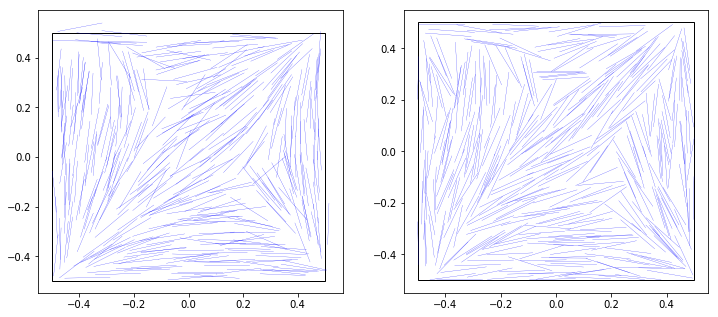

In [34]:
def get_th(v):
    return v

# indexing: epoch, something, batchloc, 3,400
# 'something' not present in yimg
ep = -1
b = np.argmax(imgIdx[start:end]) # use argmin/max for earliest/latest img in batch
rnnimg = outimgs[ep][0][b].T
yimg = outimgs[ep][1][b].T

# Note, you'll have to search for rod lengths based on files
# xmelt has boxlength of 6 -> rod length 1/6
edge = 6.0
halfL = 0.5*(1/edge)

f,ax = plt.subplots(1,2,figsize=(12,5.2))
# a = plt.Axes(f, [0., 0., 1., 1.])
# ax[0].set_axis_off()
# ax[1].set_axis_off()
# f.add_axes(a)
# plt.xlim(-w/2,w/2)
# plt.ylim(-h/2,h/2)
# plt.xticks([])
# plt.yticks([])


for rod in rnnimg:
    x,y = rod[0],rod[1]
    th = rod[2]
    th *= twopi
    x1 = x - halfL*sin(th)
    y1 = y + halfL*cos(th)
    x2 = x + halfL*sin(th)
    y2 = y - halfL*cos(th)

    plotLine(x1,y1,x2,y2,ax=ax[0])

for rod in yimg:
    x,y = rod[0],rod[1]
    th = rod[2]
    th *= twopi
    x1 = x - halfL*sin(th)
    y1 = y + halfL*cos(th)
    x2 = x + halfL*sin(th)
    y2 = y - halfL*cos(th)

    plotLine(x1,y1,x2,y2,ax=ax[1])

# For circles
radius = 0.5
boundary1 = pypatch.Rectangle((-radius,-radius),1.,1.,color='k',fill=False)
boundary2 = pypatch.Rectangle((-radius,-radius),1.,1.,color='k',fill=False)
ax[0].add_patch(boundary1)
ax[1].add_patch(boundary2)
# ax[0].axis('off')
# ax[1].axis('off')
ax[0].figure.canvas.draw()
ax[1].figure.canvas.draw()

In [11]:
f.savefig(summdir+"/compare.png")